In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

seeed = 185

# cHANGELIST

* Loading and resizing images now done together in the same block
* Invalid image paths are removed
* More model architectures are considered.

In [3]:
import os

# Customised for Windows setup
# os.chdir('SharedFiles/MAST30034-Group-Project/')

In [4]:
# Customised for Mac/Linux setup
raw_data = pd.read_csv("kaggle_bee_vs_wasp/labels.csv")
raw_data['path'] = raw_data['path'].str.replace("\\", "/")

By removing the low quality photos, we get rid of the is_other instances

In [5]:
high_quality_entries = raw_data[raw_data["photo_quality"] == 1]
high_quality_entries =high_quality_entries[high_quality_entries["label"] != "insect"]

In [6]:
print(high_quality_entries.shape)
high_quality_entries.head()

(4596, 10)


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [7]:
[_,label_num] = np.unique(high_quality_entries["label"].values, return_inverse = True)
high_quality_entries.insert(loc = 0, column = "label_num", value = label_num)

In [8]:
print(high_quality_entries.shape)

for ind, row in high_quality_entries.iterrows():
    if not os.path.exists("kaggle_bee_vs_wasp/" + row['path']):
        #print(row)
        high_quality_entries = high_quality_entries.drop(ind)
        
print(high_quality_entries.shape)

(4596, 11)
(4592, 11)


In [9]:
# no non-insects found in the dataset
list(high_quality_entries["is_other"]).count(1)

0

In [10]:
3 in list(high_quality_entries["label_num"].values)

False

In [11]:
#taking a random sample for faster training time
# high_quality_entries = high_quality_entries.sample(1000)

In [12]:
images_path = high_quality_entries["path"].values.reshape(-1, 1)
labels = high_quality_entries["label"].values.reshape(-1, 1)

# Data

In [13]:
from matplotlib.image import imread
from skimage.transform import resize

In [14]:
images = []

# random_sample = high_quality_entries.sample(10)
# Train 50 for now just to get the code running

# Read, resize, store
for image_path in images_path:
    img = imread(os.path.join("kaggle_bee_vs_wasp", image_path[0]))
    img = resize(img, (224,224))
    images.append(img)

# Removed wrong size
images_to_remove_indecies = []

for im in range(len(images)):
    if images[im].shape != (224,224,3):
        #print(im)
        images_to_remove_indecies.append(im)

for index in images_to_remove_indecies:
    print(index)

#remove the labels of the anomalous images
labels_deleted = np.delete(labels, images_to_remove_indecies)

for im in reversed(images_to_remove_indecies):
    print(im)
    del images[im]
    
image_array = np.array(images)
print('Number of images:', image_array.shape)
print('Number of labels:', labels_deleted.shape)

1667
4030
4030
1667
Number of images: (4590, 224, 224, 3)
Number of labels: (4590,)


In [15]:
# #If you need to check the images.

# #imread outputs integers between 0-255

# images[0]
# f,ax = plt.subplots(3,3)
# for i in range(3):
#     for j in range(3):
#         ax[i,j].imshow(images[i+3*j])

## Encoding the image labels

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [17]:
# Encode as integers
encoder = LabelEncoder()
transformed_label = encoder.fit_transform(np.ravel(labels_deleted))

print('number of labels:', len(transformed_label))

number of labels: 4590


In [18]:
np.unique(transformed_label, return_counts=True)

(array([0, 1]), array([2468, 2122]))

In [19]:
# OR baseline
print(max(np.unique(transformed_label, return_counts=True)[1])/len(transformed_label)) 
# 54% is the baseline

0.5376906318082789


# Data augmentation

Split a training set from a validation set first, to prevent data leakage.
Augment a training set.

https://stats.stackexchange.com/questions/175504/how-to-do-data-augmentation-and-train-validate-split

In [20]:
#Train/validation/test split
from sklearn.model_selection import train_test_split

# 15% in test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(image_array, transformed_label, 
                                              test_size = 0.15, random_state = seeed, 
                                              stratify = transformed_label)

# of 70%, 20% in validation
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, 
                                              test_size = 0.18, random_state = seeed, 
                                              stratify = Ytrain)

#70% training, 15% validation, 15% in test

print('Total:', image_array.shape, transformed_label.shape)
print('Train:', Xtrain.shape, Ytrain.shape)
print('Val:', Xval.shape, Yval.shape)
print('Test:', Xtest.shape, Ytest.shape)

Total: (4590, 224, 224, 3) (4590,)
Train: (3198, 224, 224, 3) (3198,)
Val: (703, 224, 224, 3) (703,)
Test: (689, 224, 224, 3) (689,)


In [21]:
# Augmented training data
train_generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    rotation_range=90,
    zoom_range=0.4,
    horizontal_flip=True,
    # vertical_flip==True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=0.3)

# No augmentation on validation
val_generator = keras.preprocessing.image.ImageDataGenerator()

train_generator.fit(Xtrain)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


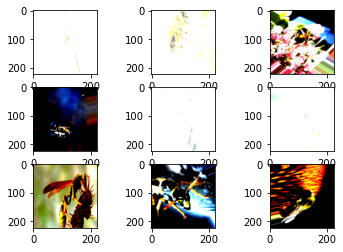

In [22]:
# If images need to be viewed, use batch size 1. Else keep batch size 32

augmented_train = train_generator.flow(Xtrain, Ytrain, batch_size=1)

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = augmented_train.next()
    # convert to unsigned integers for viewing
    image = batch[0]
#     # plot raw pixel data
    image = np.reshape(image, (224,224,3))
    plt.imshow(image)

# Model Construction

## Metrics: Accuracy and Loss

In [23]:
def plot_model_metrics(hist):

    f, ax = plt.subplots(2,1)
    f.subplots_adjust(hspace=0.6)

    ax[0].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
    ax[0].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
    ax[0].legend(['training', 'validation'])

    ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy'])))
    
    ax[0].set_xticklabels(labels=np.arange(0,len(hist.history['accuracy'])))
    ax[0].set_xlim(0,len(hist.history['accuracy']))
    ax[0].set_xlabel('Epochs')
    ax[0].set_title('Model Accuracy')

    ax[1].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
    ax[1].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
    ax[1].legend(['training', 'validation'])

    ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy'])))
    ax[1].set_xticklabels(labels=np.arange(0,len(hist.history['accuracy'])))
    ax[1].set_xlim(0,len(hist.history['accuracy']))
    ax[1].set_xlabel('Epochs')
    ax[1].set_title('Loss')
    

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_report(truth, predictions):
    '''
    Input:
        truth - true labels
        predictions - model.predict(data)
    '''
    print(classification_report(truth, np.argmax(predictions, axis=-1)))
    print(confusion_matrix(truth, np.argmax(predictions, axis=-1)))

# Model - MobileNetV2 (baseline)

3692 images in a training set. Augmented images will be generated from this set for training.

1231 unaugmented images will be used for validation.

In [25]:
mbnet = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet')
avg = keras.layers.GlobalAveragePooling2D()(mbnet.output)
#drop = keras.layers.Dropout(0.7)(avg)

# flat = keras.layers.Flatten()(mbnet.output)
# avg = keras.layers.Dense(6, activation='relu')(flat)

output = keras.layers.Dense(2, activation='softmax')(avg)

m0 = keras.Model(inputs = mbnet.input, outputs = output)

# for layer in mbnet.layers:
#     layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.01, momentum= 0.9, decay = 0.01)

m0.compile(loss="sparse_categorical_crossentropy", 
           optimizer=optimizer,
           metrics=["accuracy"])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, 
                                         min_delta = 0.005, 
                                         restore_best_weights=True)


h0 = m0.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
            epochs=23, steps_per_epoch=20,
            validation_data = (Xval, Yval),
            callbacks = [callback])

# Batches per epoch changed so that 1 epoch = 1 cycle of length len(Xtrain)

# Trains 3,200 images
# Validates on len(Yval) (should be entire validation set)

Epoch 1/23
20/20 [==============================] - 188s 9s/step - loss: 0.5686 - accuracy: 0.7688 - val_loss: 1.4699 - val_accuracy: 0.6188
Epoch 2/23
 7/20 [=========>....................] - ETA: 1:40 - loss: 0.7673 - accuracy: 0.7723

In [ ]:
# "sparse"
predss0 = m0.predict(Xtest)
predss0[0:15]

In [ ]:
plt.hist(predss0[:,0],)
plt.title('Distribution of final outputs for "bee" (test set)')
plt.xlabel('Final output')
plt.ylabel('Number of instances')
plt.savefig('Mnv2_result1.png', dpi=300)

In [ ]:
predss0 = m0.evaluate(Xtest, Ytest)

In [ ]:
confusion_report(Ytest, m0.predict(Xtest))

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(Ytest, m0.predict(Xtest))

In [ ]:
i = 0
clist =[]
for c in range(len(Xval)):
    if predss0[c,0] < 0.1 or predss0[c,0] > 0.9:
        clist.append(c)
        i += 1
        
print(i)

In [ ]:
m1.predict(Xval[78:79])

In [ ]:
plt.imshow(Xval[218])

In [ ]:
hist = h0

f, ax = plt.subplots(2,1)
f.subplots_adjust(hspace=0.5)
f.set_figwidth(6)
f.set_figheight(8)

ax[0].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
ax[0].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
ax[0].legend(['Training', 'Validation'])

ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))
ax[0].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))

ax[0].set_xlim(0,len(hist.history['accuracy']))
ax[0].set_xlabel('Training examples')
ax[0].set_title('Cross Entropy')
# ax[0].set_ylim(0.75,0.95)

ax[1].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
ax[1].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
ax[1].legend(['Training', 'Validation'])

ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))

ax[1].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))
ax[1].set_xlim(0,len(hist.history['accuracy']))
ax[1].set_xlabel('Training Examples')
ax[1].set_title('Accuracy')

f.savefig('Mbv2_BestLearningCurve.png', dpi=300)

In [ ]:
m0.evaluate(Xtest,Ytest)

In [ ]:
Xtrain.shape

In [ ]:
Ytrain[4]

In [ ]:
plot_model_metrics(h0)

In [ ]:
confusion_report(Ytrain, m0.predict(Xtrain))

In [ ]:
confusion_report(Yval, m0.predict(Xval))

In [ ]:
confusion_report(Ytest, m0.predict(Xtest))

# Model Design

Speeding up training:
* Batch normalisation, Adam optimisation

Design options
* Convolution: Window size, Stride
* Activation functions: Softmax, ReLU
* Pooling: Average, Max
* Dense layer - fully connected.

Regularisation options
* Dropout: for regularisation

Other options
* Residual block (resnet)
* Batch normalisation: makes models faster and more stable.

Design recommendations
* Multiple 3x3 convolutions are preferred. (https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15, VGGNet?)
* Downsample by using pooling to reduce spatial information
* Common paradigm is to use max pooling in the network, and average pooling at the end, before the last dense layer
* Depth tends to result in higher accuracy

After all this, try to augment the data:
* rotations
* flips
* slight colour changes (for lighting conditions)

In [ ]:
       
# Filter: number of filters to learn - to be specified
# kernel_size: height and width of filter - to be specified
# Strides = (1,1) by default (no skip).
# Padding (if a filter doesn't fit)
# Activation = 'relu' (applied after calculations)
# Bias = True by default

# Consider regularisers after
# m1.add(keras.layers.BatchNormalization())
# m1.add(keras.layers.Dropout(0.5))
# m1.add(keras.layers.Activation("relu"))
# m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# m1.add(keras.layers.GlobalAvgPool2D())
# m1.add(keras.layers.Flatten())
# m1.add(keras.layers.Dense(10, activation="softmax"))


## Original Model

In [ ]:
m1 = keras.models.Sequential()

m1.add(keras.Input(shape = (224, 224, 3)))

m1.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())

m1.add(keras.layers.Conv2D(16, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())


m1.add(keras.layers.Flatten())
m1.add(keras.layers.Dense(16, activation="relu"))
m1.add(keras.layers.BatchNormalization())

# m1.add(keras.layers.Dense(128, activation="relu"))
# # m1.add(keras.layers.GlobalAveragePooling2D())
# m1.add(keras.layers.BatchNormalization())
m1.add(keras.layers.Dense(2, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=0.001)

m1.compile(loss="sparse_categorical_crossentropy",
           optimizer=optimizer,
           metrics=["accuracy"])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.005, restore_best_weights=True)

h1 = m1.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32, seed = 32), 
            epochs=23, steps_per_epoch=20,
            validation_data = (Xval, Yval),
            callbacks=[callback])

# 32*20 = 640 examples per epoch
# 15,000/640 = 23 epochs to cycle over the original size * 3

In [ ]:
# "sparse"
predss = m1.predict(Xtest)
predss[0:15]

In [ ]:
plt.hist(predss[:,0],)
plt.axvline(0.5, c='k')
plt.xlim(0,1)
plt.title('Distribution of final outputs for "bee" (test set)')
plt.xlabel('Final output')
plt.ylabel('Number of instances')
plt.savefig('Customoutput_distribution.png', dpi=300)

In [ ]:
# 'binary'

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.005, restore_best_weights=True)

h1 = m1.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32, seed = 46), 
            epochs=23, steps_per_epoch=20,
            validation_data = (Xval, Yval),
            callbacks=[callback])

# 32*20 = 640 examples per epoch
# 15,000/640 = 23 epochs to cycle over the original size * 3

In [ ]:
predss2 = m1.predict(Xval)
predss2[0:15]

In [ ]:
f, ax = plt.subplots(1,2)
f.set_figwidth(9)
f.set_figheight(3.5)

yhat = np.arange(0,1,0.01)
ax[0].plot(yhat, -np.log(1-yhat))
ax[0].set_xlabel('estimated y')
ax[0].set_title('y=0')
ax[0].set_ylabel('Cost')


ax[1].plot(yhat, -np.log(yhat))
ax[1].set_xlabel('estimated y')
ax[1].set_title('y=1')
ax[1].set_ylabel('Cost')

f.savefig('loss.png', dpi=350)

In [ ]:

Xtrain.shape

In [ ]:
Xtrain.shape

In [ ]:
h1.model.summary()

In [ ]:
plot_model_metrics(h1)

In [ ]:
m1.evaluate(Xtest, Ytest)

In [ ]:
confusion_report(Ytrain, m1.predict(Xtrain))

In [ ]:
confusion_report(Yval, m1.predict(Xval))

In [ ]:
confusion_report(Ytest, m1.predict(Xtest))

In [ ]:
hist = h1

f, ax = plt.subplots(2,1)
f.subplots_adjust(hspace=0.5)
f.set_figwidth(6)
f.set_figheight(8)

ax[0].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
ax[0].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
ax[0].legend(['Training', 'Validation'])

ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))
ax[0].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))

ax[0].set_xlim(0,len(hist.history['accuracy']))
ax[0].set_xlabel('Training examples')
ax[0].set_title('Cross Entropy')
ax[0].set_ylim(0.40,0.75)

ax[1].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
ax[1].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
ax[1].legend(['Training', 'Validation'])

ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))

ax[1].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))
ax[1].set_xlim(0,len(hist.history['accuracy']))
ax[1].set_xlabel('Training Examples')
ax[1].set_title('Accuracy')

f.savefig('BestLearningCurve.png', dpi=300)

# M2

In [ ]:
m2 = keras.models.Sequential()

#narrow stride and pool side to capture finer details

m2.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding='same'))
m2.add(keras.layers.BatchNormalization())
m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

m2.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding='same'))
m2.add(keras.layers.BatchNormalization())
m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

m2.add(keras.layers.Flatten())
# m2.add(keras.layers.Dropout(0.3))
m2.add(keras.layers.Dense(16, activation="relu"))
m2.add(keras.layers.BatchNormalization())
m2.add(keras.layers.Dense(2, activation="softmax"))

# optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
#optimizer = keras.optimizers.Adam()

m2.compile(loss="sparse_categorical_crossentropy",
           optimizer="adam",
           metrics=['accuracy'])


In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.01)

h2 = m2.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
            epochs=23, steps_per_epoch=20,
            validation_data = (Xval, Yval),
            callbacks=[callback])

# 32*20 = 640 examples per epoch
# 15,000/640 = 23 epochs to cycle over the original size * 3

In [ ]:
h2.model.summary()

In [ ]:
plot_model_metrics(h2)

In [ ]:
m1.evaluate(Xtest, Ytest)

In [ ]:
confusion_report(Ytrain, m1.predict(Xtrain))

In [ ]:
confusion_report(Yval, m1.predict(Xval))

In [ ]:
confusion_report(Ytest, m2.predict(Xtest))

In [ ]:
hist = h2

f, ax = plt.subplots(2,1)
f.subplots_adjust(hspace=0.5)
f.set_figwidth(6)
f.set_figheight(8)

ax[0].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
ax[0].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
ax[0].legend(['Training', 'Validation'])

ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))
ax[0].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))

ax[0].set_xlim(0,len(hist.history['accuracy']))
ax[0].set_xlabel('Training examples')
ax[0].set_title('Cross Entropy')
# ax[0].set_ylim(0.75,0.95)

ax[1].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
ax[1].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
ax[1].legend(['Training', 'Validation'])

ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))

ax[1].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))
ax[1].set_xlim(0,len(hist.history['accuracy']))
ax[1].set_xlabel('Training Examples')
ax[1].set_title('Accuracy')

f.savefig('BestLearningCurve.png', dpi=300)

# Results 1

In [ ]:
# m2 = keras.models.Sequential()

# m2.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=3, strides=1, padding="same"))

# m2.add(keras.layers.Conv2D(16, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Conv2D(16, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=3, strides=1, padding="same"))

# m2.add(keras.layers.Flatten())
# m2.add(keras.layers.Dropout(0.7))
# m2.add(keras.layers.Dense(16, activation="relu"))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Dense(3, activation="softmax"))

# optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
# #optimizer = keras.optimizers.Adam()

# m2.compile(loss="sparse_categorical_crossentropy",
#            optimizer=optimizer,
#            metrics=['accuracy'])


In [ ]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.05)

# h2 = m2.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
#             epochs=23, steps_per_epoch=20,
#             validation_data = (Xval, Yval),
#             callbacks=[callback])

# # 32*20 = 640 examples per epoch
# # 15,000/640 = 23 epochs to cycle over the original size * 3

In [ ]:
# plot_model_metrics(h2)

# Result 2

In [ ]:
# m2 = keras.models.Sequential()

# m2.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Flatten())
# m2.add(keras.layers.Dropout(0.7))
# m2.add(keras.layers.Dense(16, activation="relu"))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Dense(3, activation="softmax"))

# optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
# #optimizer = keras.optimizers.Adam()

# m2.compile(loss="sparse_categorical_crossentropy",
#            optimizer=optimizer,
#            metrics=['accuracy'])


In [ ]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.05)

# h2 = m2.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
#             epochs=23, steps_per_epoch=20,
#             validation_data = (Xval, Yval),
#             callbacks=[callback])

# # 32*20 = 640 examples per epoch
# # 15,000/640 = 23 epochs to cycle over the original size * 3

In [ ]:
# plot_model_metrics(h2)

# results3

In [ ]:
# plot_model_metrics(h2

In [ ]:
# m2 = keras.models.Sequential()

# #narrow stride and pool side to capture finer details

# m2.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Flatten())
# m2.add(keras.layers.Dropout(0.7))
# m2.add(keras.layers.Dense(16, activation="relu"))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Dense(3, activation="softmax"))

# optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
# #optimizer = keras.optimizers.Adam()

# m2.compile(loss="sparse_categorical_crossentropy",
#            optimizer=optimizer,
#            metrics=['accuracy'])


In [ ]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.05)

# h2 = m2.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
#             epochs=23, steps_per_epoch=20,
#             validation_data = (Xval, Yval),
#             callbacks=[callback])

# # 32*20 = 640 examples per epoch
# # 15,000/640 = 23 epochs to cycle over the original size * 3